In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Zad.1

In [2]:
def random_population(chromosome_length, mi, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        res[num_of_child, 0, :]=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [3]:
def parent_selection(P, evaluation_result, lambda_param):
    indices=np.random.choice(len(evaluation_result), lambda_param)
    return P[indices]

In [4]:
def mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
        P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
    return P_children

In [154]:
def replacement(it, P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=True, looking_for_max=False):
    if not is_mi_plus_lambda:
        indices=np.argsort(-children_evaluation_result)[:mi_param] if looking_for_max else np.argsort(children_evaluation_result)[:mi_param]
        return  P_children[indices], children_evaluation_result[indices]
    else:
        all_evaluation_results=np.concatenate((evaluation_result, children_evaluation_result))
        full_population=np.concatenate((P, P_children))
        indices=np.argsort(-all_evaluation_results)[:mi_param] if looking_for_max else np.argsort(all_evaluation_results)[:mi_param]
        return full_population[indices], all_evaluation_results[indices]

In [155]:
def eval_population(objective_function, population):
    population_size=len(population)
    results=np.zeros(population_size)
    for i in range(population_size):
        results[i] = objective_function(population[i])
    return results

In [158]:
def ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=random_population(chromosome_length, mi_param, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(i, P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
        min=evaluation_result.min()
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

In [108]:
def plot_chart(P):
    plt.figure(figsize=(20, 7))
    plt.plot(P[1], label="Max results")
    plt.plot(P[2], label="Mean results")
    plt.plot(P[3], label="Min results")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.show()

## Benchmarks:

Sphere

In [109]:
def sphere(individual):
    return np.sum(individual * individual)
print(sphere(np.array([1.0, 2.0, 3.0])))

14.0


Mi + lambda

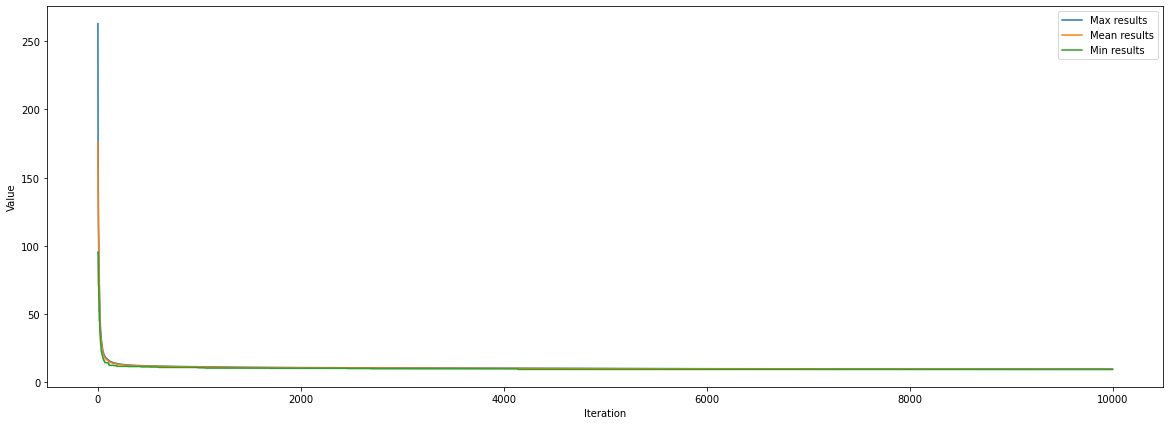

[ 0.29451388  0.05475472  0.02678067  0.08368238 -0.09645197  0.03859581
 -2.89561393  0.12578248 -0.23524158  0.10748349  0.14693229 -0.03621316
  0.27647293 -0.11954795 -0.30703785  0.08550103  0.17535154  0.14681397
  0.59870413 -0.10742082]


In [51]:
res=ES_mi_lambda(sphere, 20, 100, 100, (-5.12, 5.12))
plot_chart(res)
print(res[0])

Mi, lambda

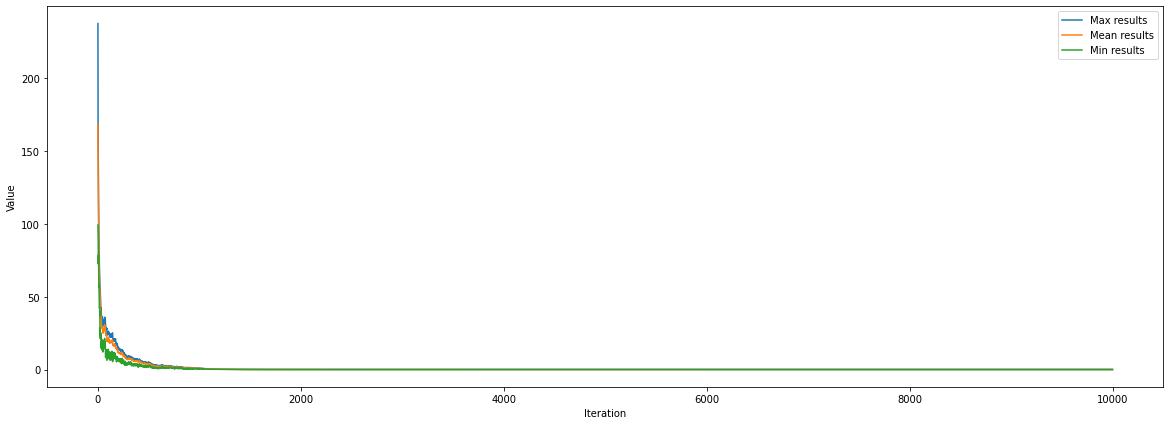

[-4.34925007e-10  2.02322134e-10  2.05286012e-10  8.11866048e-10
  1.03165517e-09  6.05707577e-11  7.87330923e-11  4.96461572e-10
  3.31915344e-10 -5.55984809e-10 -8.34794503e-11  2.20467125e-10
  8.60567770e-12  8.96056780e-11 -2.04817731e-10 -1.44392294e-10
  9.36368807e-10  2.56419439e-10  8.40289505e-11  4.28459587e-10]


In [160]:
res=ES_mi_lambda(sphere, 20, 100, 200, (-5.12, 5.12), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Sum squares

In [61]:
def sum_squares(individual):
    return np.sum(np.arange(1, len(individual) + 1) * individual * individual)
print(sum_squares(np.array([1.0, 2.0, 3.0])))

36.0


Mi + lambda

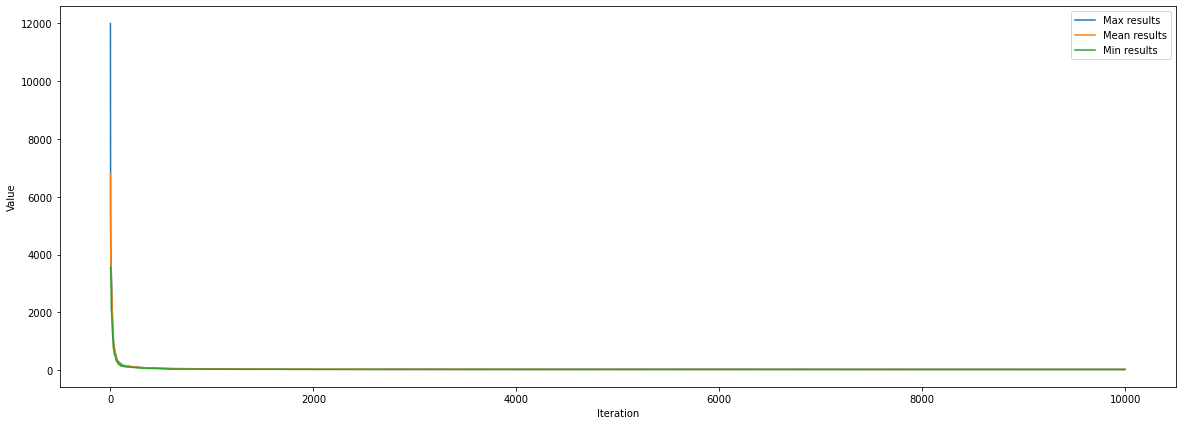

[-0.77407742  0.11512605 -0.10151288  0.22343331  0.42896061 -0.09568577
 -0.51304067  0.05292461  1.37646675  0.00410114  0.06299962 -0.21162327
 -0.1498966   0.04042094 -0.06969094 -0.11502102  0.10510768  0.10096203
  0.09679349 -0.09119291]


In [54]:
res=ES_mi_lambda(sum_squares, 20, 100, 100, (-10, 10))
plot_chart(res)
print(res[0])

Mi, lambda

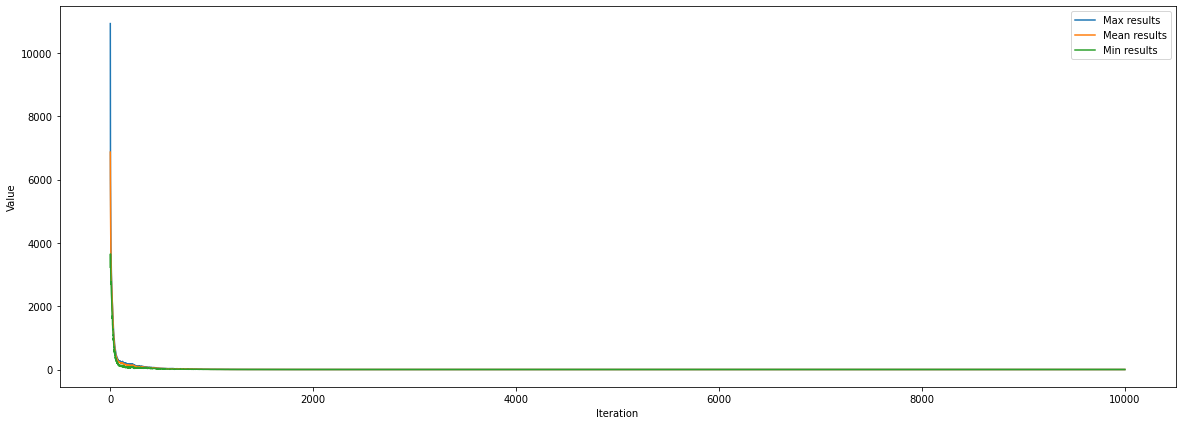

[-5.31853986e-10  3.31095261e-10 -2.58091585e-10  1.25336786e-10
  7.63758532e-10 -5.00456385e-10  3.75823135e-10 -1.09078889e-11
 -8.84093926e-11  1.08206123e-10  2.26992889e-10  3.54285232e-10
 -1.84256760e-10  5.00726711e-11  2.32583034e-13 -9.84789427e-12
  2.12764458e-10  1.65845275e-10  2.25470211e-10  1.41756068e-10]


In [161]:
res=ES_mi_lambda(sum_squares, 20, 100, 200, (-10, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Griewank

In [119]:
def griewank(individual):
    return (np.sum(individual*individual) / 4000) - np.prod(np.cos(individual / np.sqrt(np.arange(1, len(individual) + 1)))) + 1

Mi + lambda

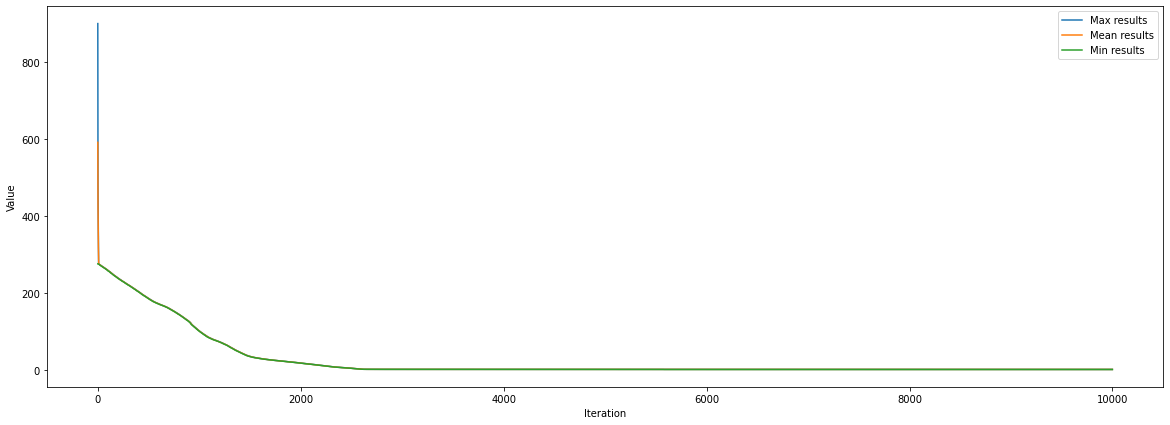

[ 12.7274802   -0.06725847 -11.20979409  -0.89774603  -0.88756555
   0.52812938   1.01729117   0.09384536  -1.49849342  -0.84996099
  -0.09209826  -0.89355176  -0.92822066  -1.18428033   0.47583957
   0.29380782   1.16783511   0.56343397  -1.44848701  -1.46715974]


In [120]:
res=ES_mi_lambda(griewank, 20, 100, 100, (-600, 600))
plot_chart(res)
print(res[0])

Mi, lambda

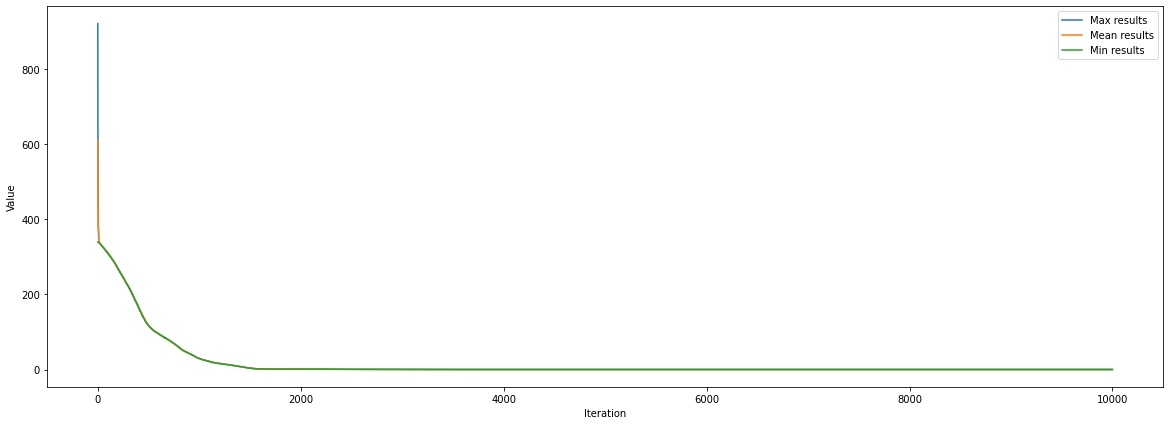

[-8.63066844e-09 -1.25041737e-08  2.51282187e-08 -3.18900786e-08
 -3.10168316e-10  6.24733417e-09 -1.15636465e-09  8.12848112e-09
  3.10827661e-08  4.05752354e-09  3.07383903e-08  5.50952918e-08
  1.63732661e-08  2.19519560e-09 -5.41421682e-10  4.73124625e-09
 -1.93960821e-08 -2.90236669e-08 -1.05074757e-08  3.20185245e-08]


In [162]:
res=ES_mi_lambda(griewank, 20, 100, 200, (-600, 600), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Rastrigin

In [149]:
def rastrigin(individual):
    return 10 * len(individual) + np.sum(individual * individual - 10 * np.cos(2 * np.pi * individual))
print(rastrigin(np.array([1.0, 4.0, 5.0])))

42.0


Mi + lambda

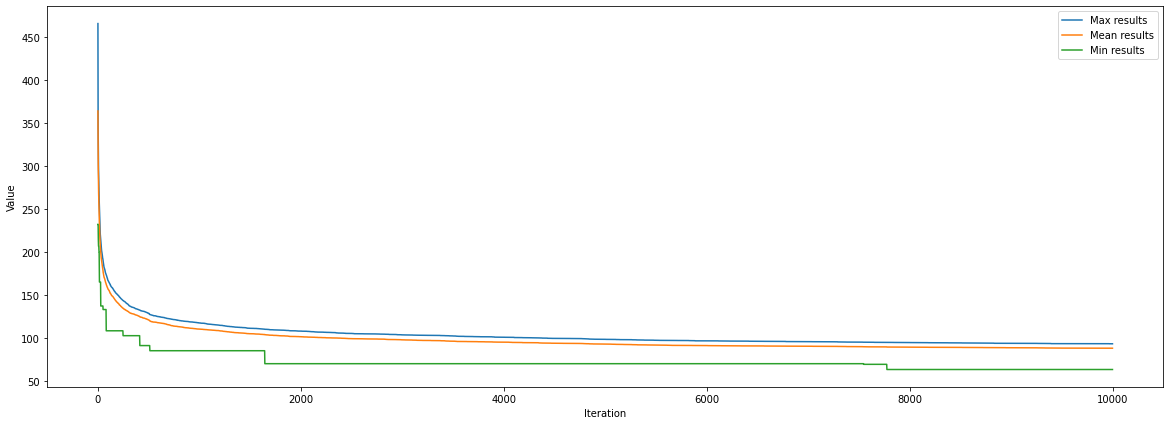

[-1.14371104e+00  1.11716969e+00  2.00656473e+00  1.46105750e-03
 -8.00650206e-02  4.54947600e-02 -7.21134776e-02 -4.99131779e-02
 -5.87032878e-02  4.02346197e+00 -1.54234119e-01 -1.25651949e-01
  1.05076105e+00  3.37765997e-02  2.05737547e+00 -9.11178855e-01
  5.71689869e-02 -3.06409013e+00 -1.09470518e+00 -3.06165837e-02]


In [166]:
res=ES_mi_lambda(rastrigin, 20, 200, 200, (-5.12, 5.12))
plot_chart(res)
print(res[0])

Mi, lambda

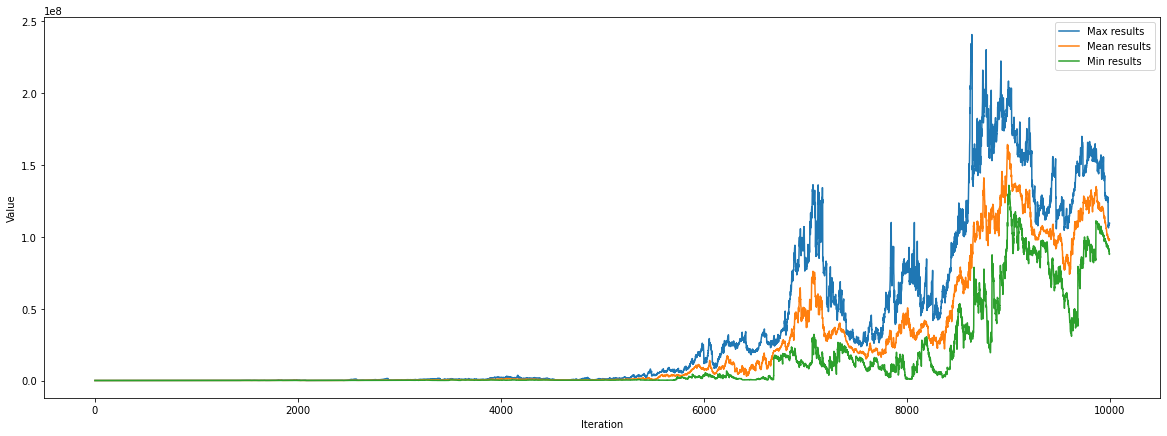

[ 1.71818750e+00 -2.55927003e+02 -2.42957419e+00 -5.76997388e+00
  4.85813385e+00  1.60669317e+02 -8.09503032e+00  2.01471673e+01
  1.59259015e+03 -5.86440818e+02 -2.68374098e+00 -3.98669800e+01
 -2.92044123e+02 -9.10385078e+03 -2.10355414e+01  2.00504358e+02
 -5.34849775e+00  6.81941762e+02  3.21158265e+00  2.69999579e+00]


In [165]:
res=ES_mi_lambda(rastrigin, 20, 200, 100, (-5.12, 5.12), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

Rosenbrock

In [167]:
def rosenbrock(individual):
    return np.sum(100 * (individual[:len(individual) -1] ** 2 - individual[1:]) ** 2 + (1 - individual[:len(individual) -1]) ** 2)
rosenbrock(np.array([0.0, 0.0, 0.0]))

2.0

Mi + lambda

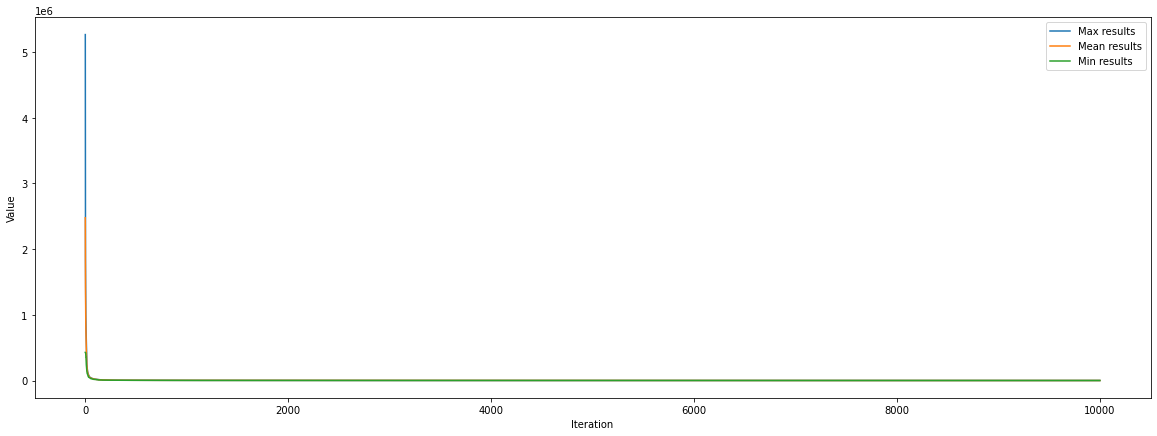

[-0.02080154 -0.07790613  0.20723324  0.05932986  0.20072413  0.13463547
  0.10800556 -0.01313519  0.16166213 -0.09823817  0.30142652  0.26407277
 -0.08797015 -0.31218763  0.34594964  0.15075215 -0.13843686 -1.18190154
  1.38584536  1.86322318]


In [168]:
res=ES_mi_lambda(rosenbrock, 20, 100, 100, (-5, 10))
plot_chart(res)
print(res[0])

Mi, lambda

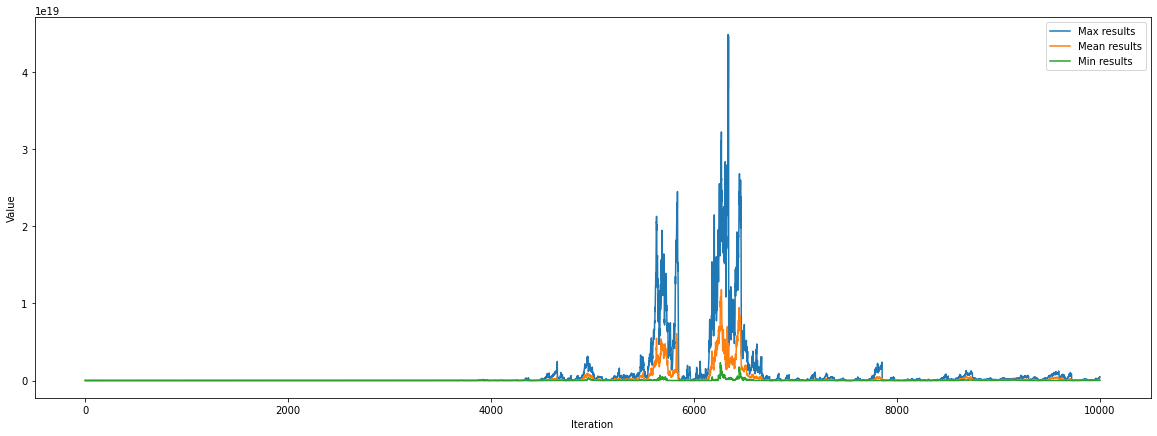

[-9.82862872e+00 -3.40374123e+02 -1.54750260e+01  8.90079193e+02
 -3.00960166e+03  4.94434190e+01 -9.73272314e+01  5.87528893e+01
 -9.16170403e+00  6.95742373e-01  3.95973761e+01 -1.86607680e+03
 -1.26311447e+02  4.65584060e+02 -3.29908476e+01  3.61918815e+00
  4.14920594e+00  1.74517617e+02  1.03507640e+01  2.35463436e+03]


In [170]:
res=ES_mi_lambda(rosenbrock, 20, 100, 50, (-5, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

## Zad.2

In [62]:
def constrained_random_population(chromosome_length, mi, restrictions, x_bounds, s_bounds):
    res=np.full((mi, 2, chromosome_length), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        while(not restrictions(candidate)):
            candidate=np.random.uniform(x_bounds[0], x_bounds[1], chromosome_length)
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], chromosome_length)
    return res

In [99]:
def constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, chromosome_length) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        loop_times=1
        while(True):
            tmp = P_children[i, 0, :]
            epsilons_for_first_chromosome = np.random.normal(0, 1, chromosome_length) * P_children[i, 1, :]
            P_children[i, 0, :] = P_children[i, 0, :] + epsilons_for_first_chromosome
            if(restrictions(P_children[i, 0, :])):
                break
            P_children[i, 0, :] = tmp
            if loop_times > 10000:
                break
            loop_times += 1
    return P_children

In [100]:
def constrained_ES_mi_lambda(objective_function, chromosome_length, mi_param, lambda_param, restrictions, x_bounds, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000, looking_for_max=False):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*chromosome_length)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(chromosome_length))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population(chromosome_length, mi_param, restrictions, x_bounds, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 200 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, chromosome_length, restrictions)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda, looking_for_max)
    best_index = evaluation_result.argmax() if looking_for_max else evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

G2

In [69]:
def G2_restrictions(individual):
    return np.sum(individual) <= 7.5 * len(individual) and np.prod(individual) >= 0.75

In [70]:
def G2_objective_function(individual):
    return np.abs((np.sum(np.cos(individual) ** 4) - 2 * np.prod(np.cos(individual) ** 2)) / np.sqrt(sum_squares(individual)))

Iter number: 0
Iter number: 2000
Iter number: 4000
Iter number: 6000
Iter number: 8000


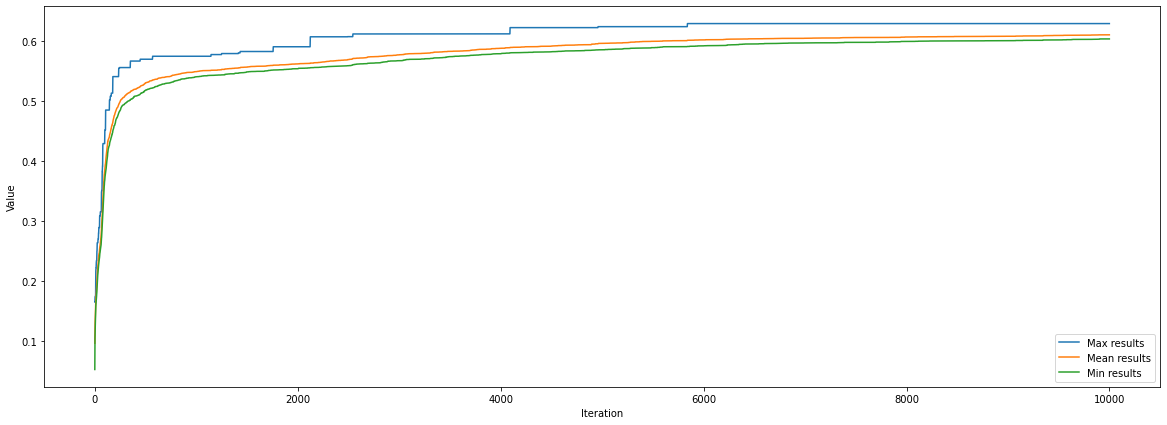

[-3.15980573 -3.32620683  2.78796802  2.62513226 -0.26539796  3.20902381
  3.11673855  3.11081828  0.49697716 -0.35444157 -2.91970346 -0.44555255
  0.57296719 -1.00365369 -0.14333673 -0.2325952  -0.42385125  0.43314532
  0.51462547  2.92471867]


In [71]:
res=constrained_ES_mi_lambda(G2_objective_function, 20, 100, 100, G2_restrictions, (0, 10), looking_for_max=True)
plot_chart(res)
print(res[0])

In [72]:
res=constrained_ES_mi_lambda(G2_objective_function, 20, 100, 100, G2_restrictions, (0, 10), is_mi_plus_lambda=False, looking_for_max=True)
plot_chart(res)
print(res[0])

Iter number: 0


KeyboardInterrupt: 

G6

In [101]:
def G6_restrictions(individual):
    return (individual[0] - 5) ** 2 +  (individual[1] - 5) ** 2 >= 100 and (individual[0] - 6) ** 2 +  (individual[1] - 5) ** 2 <= 82.81  

In [102]:
def G6_objective_function(individual):
    return (individual[0] - 10) ** 3 + (individual[1] - 20) ** 3

In [103]:
def constrained_random_population_for_g6(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        while(not G6_restrictions(candidate)):
            candidate=np.concatenate((np.random.uniform(13, 15.1, 1), np.random.uniform(0, 14.1, 1)))
        res[num_of_child, 0, :]=candidate
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res
constrained_random_population_for_g6(10, (0, 1))

array([[[14.2004298 ,  1.05953978],
        [ 0.82113749,  0.8814034 ]],

       [[14.92945034,  3.39079897],
        [ 0.23824455,  0.04493697]],

       [[14.91931205,  3.45145114],
        [ 0.40912693,  0.12961275]],

       [[14.8870166 ,  6.80326961],
        [ 0.67661633,  0.31152506]],

       [[15.07772837,  5.06318424],
        [ 0.60917556,  0.36531928]],

       [[14.71942635,  2.56180448],
        [ 0.22824255,  0.39855823]],

       [[14.91476311,  3.44182276],
        [ 0.42135127,  0.43825212]],

       [[14.87706945,  6.66638647],
        [ 0.53506334,  0.60647391]],

       [[14.96388086,  3.78456053],
        [ 0.87327472,  0.23167053]],

       [[15.00992519,  4.12224318],
        [ 0.72347809,  0.1979304 ]]])

In [106]:
def constrained_ES_mi_lambda_for_g6(objective_function, mi_param, lambda_param, restrictions, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=1000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g6(mi_param, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 10 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation(P_children, tau_param, tau_zero_param, lambda_param, 2, restrictions)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Iter number: 0
Iter number: 10
Iter number: 20
Iter number: 30
Iter number: 40
Iter number: 50
Iter number: 60
Iter number: 70
Iter number: 80
Iter number: 90
Iter number: 100
Iter number: 110
Iter number: 120
Iter number: 130
Iter number: 140
Iter number: 150
Iter number: 160
Iter number: 170
Iter number: 180
Iter number: 190
Iter number: 200
Iter number: 210
Iter number: 220
Iter number: 230
Iter number: 240
Iter number: 250
Iter number: 260
Iter number: 270
Iter number: 280
Iter number: 290
Iter number: 300
Iter number: 310
Iter number: 320
Iter number: 330
Iter number: 340
Iter number: 350
Iter number: 360
Iter number: 370
Iter number: 380
Iter number: 390
Iter number: 400
Iter number: 410
Iter number: 420
Iter number: 430
Iter number: 440
Iter number: 450
Iter number: 460
Iter number: 470
Iter number: 480
Iter number: 490
Iter number: 500
Iter number: 510
Iter number: 520
Iter number: 530
Iter number: 540
Iter number: 550
Iter number: 560
Iter number: 570
Iter number: 580
Iter num

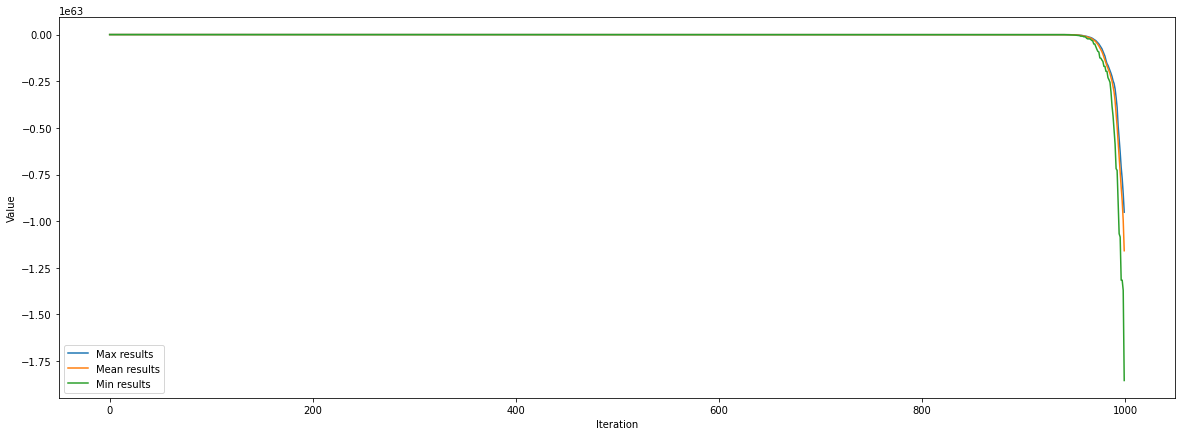

[-1.25490142e+21  2.11957956e+06]


In [107]:
res=constrained_ES_mi_lambda_for_g6(G6_objective_function, 50, 50, G6_restrictions)
plot_chart(res)
print(res[0])

G8

In [102]:
def G8_restrictions(individual):
    return individual[0] ** 2 + 1 <= individual[1] and 1 + (individual[1] - 4) ** 2 <= individual[0]
constrained_random_population(2, 10, G8_restrictions, (0, 10), (0, 1))

array([[[1.60688314, 4.55579783],
        [0.52619333, 0.80558485]],

       [[1.22200607, 4.06835621],
        [0.60491945, 0.98478235]],

       [[1.76494408, 4.58716248],
        [0.01627625, 0.28549779]],

       [[1.87381813, 4.70279357],
        [0.53546823, 0.5229054 ]],

       [[1.35511363, 3.54435539],
        [0.53726012, 0.91753567]],

       [[1.54010791, 3.79981084],
        [0.80385637, 0.08501599]],

       [[1.01808014, 4.08792216],
        [0.90167235, 0.93065303]],

       [[1.69308101, 4.5809021 ],
        [0.36738996, 0.58749209]],

       [[1.37937443, 3.58014189],
        [0.113986  , 0.57803216]],

       [[1.38089452, 3.90084506],
        [0.98176362, 0.30339269]]])

In [103]:
def G8_objective_function(individual):
    return ((np.sin(2 * np.pi * individual[0]) ** 3) * np.sin(2 * np.pi * individual[1])) / (individual[0] ** 4 + (individual[0] ** 3) * individual[1])
G2_objective_function([2.0, 0.0])

0.34181715310286465

In [104]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 100, G8_restrictions, (0, 10), looking_for_max=True)
plot_chart(res)
print(res[0])

Iter number: 0


KeyboardInterrupt: 

In [ ]:
res=constrained_ES_mi_lambda(G8_objective_function, 2, 100, 100, G8_restrictions, (0, 10), is_mi_plus_lambda=False, looking_for_max=True)
plot_chart(res)
print(res[0])

G11

In [82]:
def G11_objective_function(individual):
    return (individual[0] ** 2) + (individual[1] - 1) ** 2

In [83]:
def constrained_random_population_for_g11(mi, s_bounds):
    res=np.full((mi, 2, 2), 0.0)
    for num_of_child in range(mi):
        candidate=np.random.uniform(-1, 1, 1)[0]
        res[num_of_child, 0, :]=np.array([candidate, candidate ** 2])
        res[num_of_child, 1, :]=np.random.uniform(s_bounds[0], s_bounds[1], 2)
    return res

In [84]:
def constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param):
    for i in range(lambda_param):
        epsilon_zero = np.random.normal(0, tau_param*tau_param, 1)
        epsilons_i = np.random.normal(0, tau_zero_param*tau_zero_param, 2) + epsilon_zero
        P_children[i, 1, :] = P_children[i, 1, :] * np.exp(epsilons_i)
        tmp = P_children[i, 0, :]
        epsilons_for_first_chromosome = (np.random.normal(0, 1, 1) * P_children[i, 1, 0])
        P_children[i, 0, 0] = P_children[i, 0, 0] + epsilons_for_first_chromosome
        P_children[i, 0, 1] =  P_children[i, 0, 0] ** 2
        P_children[i, 0, :] = tmp
    return P_children

In [85]:
def constrained_ES_mi_lambda_for_g11(objective_function, mi_param, lambda_param, s_bounds=(0, 1), is_mi_plus_lambda=True,
                      tau_param=None, tau_zero_param=None, iterations_number=10000):
    if tau_param is None:
        tau_param=0.5/np.sqrt(2*2)
    if tau_zero_param is None:
        tau_zero_param=0.5/np.sqrt(2*np.sqrt(2))
    min_evaluation_results=[]
    mean_evaluation_results=[]
    max_evaluation_results=[]
    P=constrained_random_population_for_g11(mi_param, s_bounds)
    evaluation_result=eval_population(objective_function, P[:, 0, :])
    for i in range(iterations_number):
        if i % 200 == 0:
            print(f"Iter number: {i}")
        max_evaluation_results.append(np.max(evaluation_result))
        mean_evaluation_results.append(np.mean(evaluation_result))
        min_evaluation_results.append(np.min(evaluation_result))
        P_children=parent_selection(P, evaluation_result, lambda_param)
        P_children=constrained_mutation_for_g11(P_children, tau_param, tau_zero_param, lambda_param)
        children_evaluation_result=eval_population(objective_function, P_children[:, 0, :])
        P, evaluation_result= replacement(P, evaluation_result, P_children, children_evaluation_result, mi_param, is_mi_plus_lambda=is_mi_plus_lambda)
    best_index = evaluation_result.argmin()
    return P[best_index, 0, :], max_evaluation_results, mean_evaluation_results, min_evaluation_results

Iter number: 0
Iter number: 200
Iter number: 400
Iter number: 600
Iter number: 800
Iter number: 1000
Iter number: 1200
Iter number: 1400
Iter number: 1600
Iter number: 1800
Iter number: 2000
Iter number: 2200
Iter number: 2400
Iter number: 2600
Iter number: 2800
Iter number: 3000
Iter number: 3200
Iter number: 3400
Iter number: 3600
Iter number: 3800
Iter number: 4000
Iter number: 4200
Iter number: 4400
Iter number: 4600
Iter number: 4800
Iter number: 5000
Iter number: 5200
Iter number: 5400
Iter number: 5600
Iter number: 5800
Iter number: 6000
Iter number: 6200
Iter number: 6400
Iter number: 6600
Iter number: 6800
Iter number: 7000
Iter number: 7200
Iter number: 7400
Iter number: 7600
Iter number: 7800
Iter number: 8000
Iter number: 8200
Iter number: 8400
Iter number: 8600
Iter number: 8800
Iter number: 9000
Iter number: 9200
Iter number: 9400
Iter number: 9600
Iter number: 9800


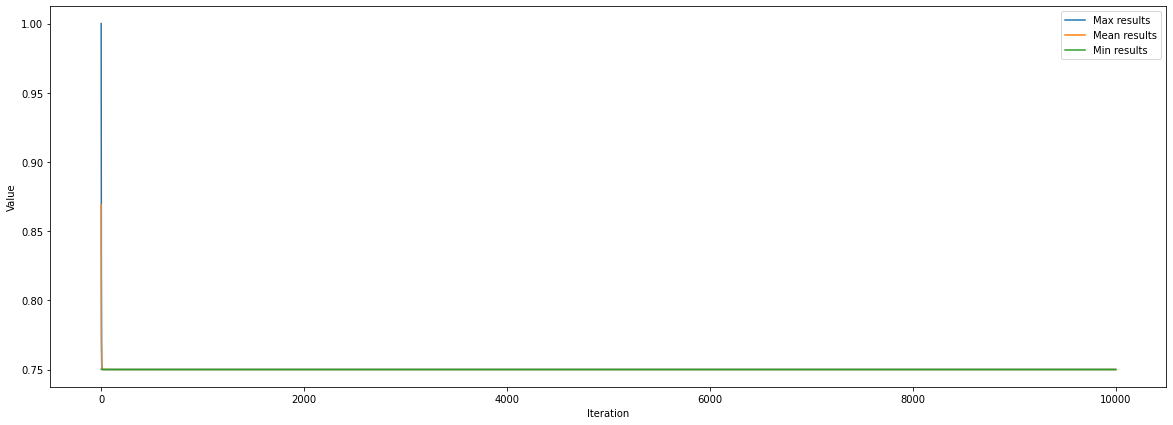

[-0.70710675  0.49999995]


In [86]:
res=constrained_ES_mi_lambda_for_g11(G11_objective_function, 100, 100)
plot_chart(res)
print(res[0])

Iter number: 0
Iter number: 200
Iter number: 400
Iter number: 600
Iter number: 800
Iter number: 1000
Iter number: 1200
Iter number: 1400
Iter number: 1600
Iter number: 1800
Iter number: 2000
Iter number: 2200
Iter number: 2400
Iter number: 2600
Iter number: 2800
Iter number: 3000
Iter number: 3200
Iter number: 3400
Iter number: 3600
Iter number: 3800
Iter number: 4000
Iter number: 4200
Iter number: 4400
Iter number: 4600
Iter number: 4800
Iter number: 5000
Iter number: 5200
Iter number: 5400
Iter number: 5600
Iter number: 5800
Iter number: 6000
Iter number: 6200
Iter number: 6400
Iter number: 6600
Iter number: 6800
Iter number: 7000
Iter number: 7200
Iter number: 7400
Iter number: 7600
Iter number: 7800
Iter number: 8000
Iter number: 8200
Iter number: 8400
Iter number: 8600
Iter number: 8800
Iter number: 9000
Iter number: 9200
Iter number: 9400
Iter number: 9600
Iter number: 9800


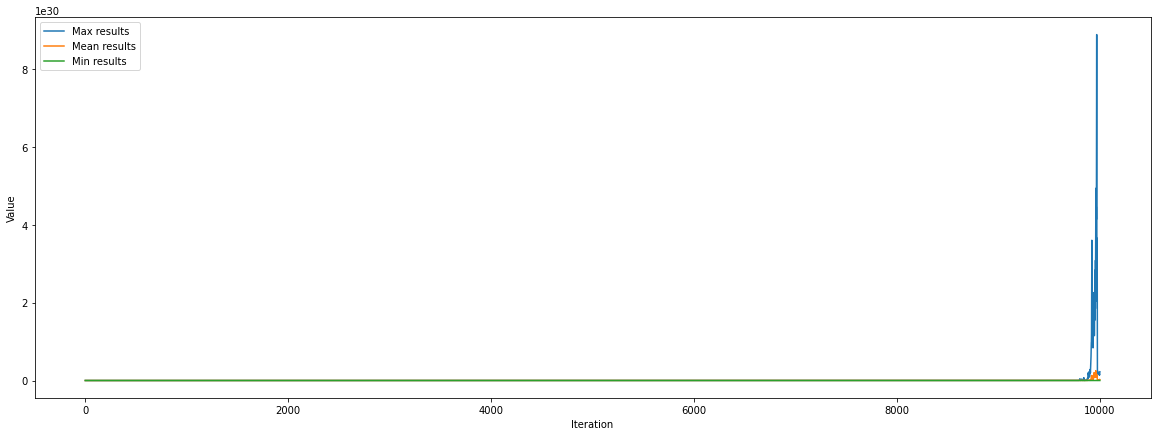

[1.39901783e+05 1.95725089e+10]


In [87]:
res=constrained_ES_mi_lambda_for_g11(G11_objective_function, 100, 100, is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])

G12

In [105]:
def G12_restrictions(individual):
    for i in ([np.floor(individual[0]), np.ceil(individual[0])]):
        for j in ([np.floor(individual[1]), np.ceil(individual[1])]):
            for k in ([np.floor(individual[2]), np.ceil(individual[2])]):
                if i > 0 and i < 10 and j > 0 and j < 10 and k > 0 and k < 10 and (individual[0] - i) ** 2 + (individual[1] - j) ** 2 + (individual[2] - k) ** 2 <= 0.0625:
                    return True
    return False
constrained_random_population(3, 10, G12_restrictions, (0, 10), (0, 1))

array([[[2.14742564, 8.13401028, 7.12999457],
        [0.4359709 , 0.77296164, 0.92190926]],

       [[5.10709691, 6.06865791, 0.9837498 ],
        [0.84108254, 0.95943448, 0.49981141]],

       [[4.95409843, 1.83913084, 1.93047433],
        [0.72284927, 0.4282301 , 0.07217054]],

       [[4.89725574, 6.08469471, 0.9608431 ],
        [0.70402243, 0.71918396, 0.5192612 ]],

       [[8.01065215, 1.08361394, 9.08231174],
        [0.23918077, 0.20127074, 0.26149252]],

       [[2.97569015, 6.23041617, 0.92745753],
        [0.81559821, 0.17894003, 0.79519561]],

       [[0.99319754, 7.97398024, 3.79107467],
        [0.94757754, 0.865835  , 0.04029463]],

       [[7.02049889, 1.87932752, 4.84268833],
        [0.72270961, 0.92288811, 0.33995741]],

       [[5.90471866, 8.08554047, 8.83194123],
        [0.1082475 , 0.53544207, 0.24028479]],

       [[8.00129254, 8.02781826, 3.7915092 ],
        [0.8043064 , 0.11447775, 0.64554055]]])

In [106]:
def G12_objective_function(individual):
    return 1 - 0.01 * ((individual[0] - 5) ** 2 + (individual[1] - 5) ** 2 + (individual[2] - 5) ** 2)
G12_objective_function(np.array([10.0, 10.0, 10.0]))

0.25

In [107]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 100, G12_restrictions, (0, 10))
plot_chart(res)
print(res[0])

Iter number: 0


KeyboardInterrupt: 

In [ ]:
res=constrained_ES_mi_lambda(G12_objective_function, 3, 100, 100, G12_restrictions, (0, 10), is_mi_plus_lambda=False)
plot_chart(res)
print(res[0])